# Imports and reading in data

In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import yellowbrick
import tensorflow as tf
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')

# Import the displaCy library
from spacy import displacy

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
plt.style.use('seaborn-talk')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Reading in data

In [4]:
df = pd.read_csv('drive/My Drive/judge-1377884607_tweet_product_company.csv',encoding = "ISO-8859-1")

df.head(20)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [5]:
df.fillna('unknown', inplace=True) 

In [6]:
df.isnull().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

# Preprocessing

## Renaming columns

In [7]:
df = df.rename(columns={"tweet_text": "text", "emotion_in_tweet_is_directed_at":"direction", "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"})

df

,text,direction,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",unknown,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",unknown,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,unknown,No emotion toward brand or product


In [8]:
df.sentiment.value_counts(dropna=False)

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [9]:
df.sentiment = df.sentiment.map({'Positive emotion': 2, 'No emotion toward brand or product':1, "I can't tell":1, 'Negative emotion': 0})

In [10]:
df.sentiment.value_counts(dropna=False)

1    5545
2    2978
0     570
Name: sentiment, dtype: int64

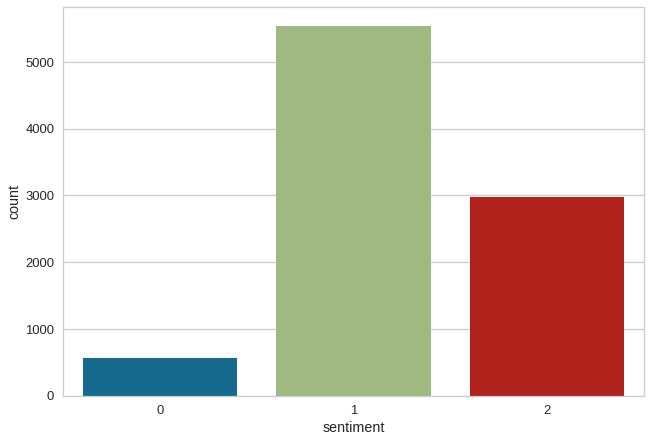

In [11]:
sns.countplot(df.sentiment)

In [12]:
df.direction.value_counts(dropna=False)

unknown                            5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: direction, dtype: int64

In [13]:
df.direction = df.direction.map({'iPad':0, 'Apple':0,'iPad or iPhone App':0,'iPhone':0,'Other Apple product or service':0,'Google':1,'Other Google product or service':1,'Android App':1,'Android':1, 'unknown':2})

In [14]:
df.direction.value_counts(dropna=False)

2    5802
0    2409
1     882
Name: direction, dtype: int64

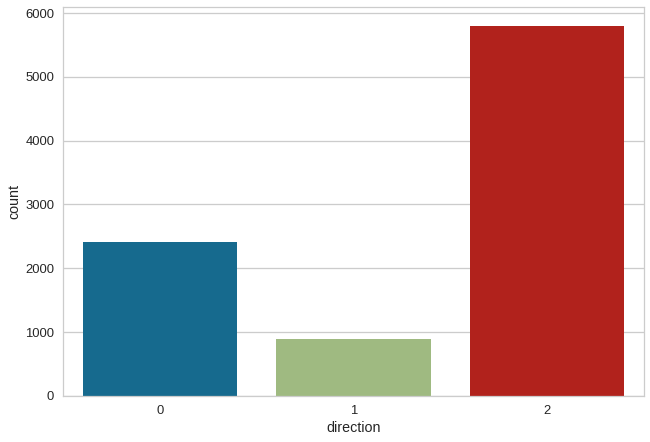

In [15]:
sns.countplot(df.direction)

In [16]:
def preprocess(text):
    text = text.str.replace("(<br/>)", "")
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('(&amp)', '')
    text = text.str.replace('(&gt)', '')
    text = text.str.replace('(&lt)', '')
    text = text.str.replace('(\xa0)', ' ')  
    return text

clean_df = df 
clean_df['text'] = preprocess(clean_df['text'])

clean_df['text']

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9093, dtype: object

In [17]:
clean_df['tweet_len'] = clean_df['text'].astype(str).apply(len)
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))

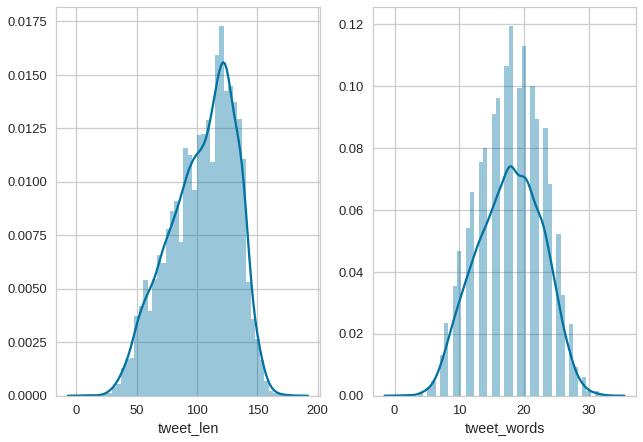

In [18]:
fig, axs = plt.subplots(ncols=2)
sns.distplot(clean_df['tweet_len'], ax=axs[0])
sns.distplot(clean_df['tweet_words'], ax=axs[1])

In [19]:
clean_df.head()

,text,direction,sentiment,tweet_len,tweet_words
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0,0,127,23
1,@jessedee Know about @fludapp ? Awesome iPad/i...,0,2,139,22
2,@swonderlin Can not wait for #iPad 2 also. The...,0,2,79,15
3,@sxsw I hope this year's festival isn't as cra...,0,0,82,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1,2,127,17


In [20]:
corpus = clean_df['text'].to_list()
corpus[:10]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) ; Matt Mullenweg (Wordpress)",
 '@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd',
 'unknown',
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit

In [21]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer() 
  
text_tokens = tk.tokenize(','.join(corpus))



In [22]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
tokens_clean = [word.lower() for word in text_tokens if word.lower() not in stopwords_list]

print(tokens_clean[:10])

['.', '@wesley83', '3g', 'iphone', '.', '3', 'hrs', 'tweeting', '#rise_austin', ',']


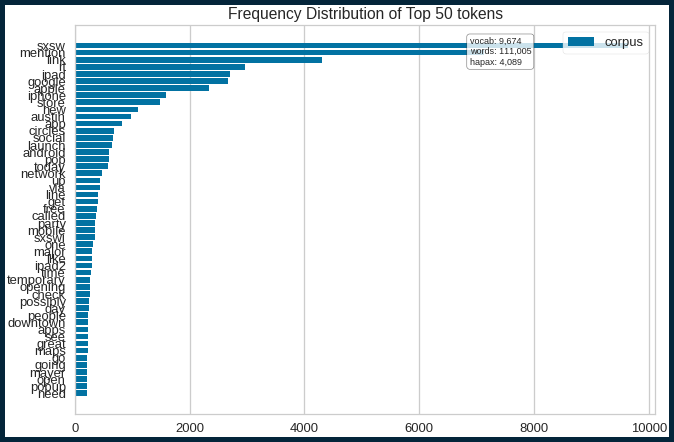

<Figure size 748.8x514.8 with 0 Axes>

In [24]:
fig = plt.figure(linewidth=10, edgecolor="#04253a")
vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(tokens_clean)
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()
plt.tight_layout()

## TO DO: T-sne

In [25]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from yellowbrick.text import TSNEVisualizer

# # Load the data and create document vectors
# tfidf = TfidfVectorizer()

# X = tfidf.fit_transform(clean_df['text'])
# y = clean_df['sentiment']

# # Create the visualizer and draw the vectors
# tsne = TSNEVisualizer()
# tsne.fit(X, y)
# tsne.show()

KeyboardInterrupt: ignored

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(*zip(*transformed_data_3d))
# plt.show()

In [26]:
string_df= clean_df['text'].to_string()

In [27]:
doc = nlp(string_df)

In [28]:
from wordcloud import WordCloud

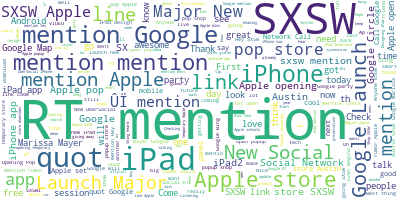

In [29]:
# Join the different processed titles together.
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(clean_df['text'].to_string())
# Visualize the word cloud
wordcloud.to_image()

In [30]:
#LDA would go here

# Modeling

In [31]:
from sklearn_pandas import DataFrameMapper, cross_val_score

In [32]:
mapper = DataFrameMapper([
     ('text', TfidfVectorizer()),
     ('direction', None),
     ('tweet_len', None),
     ('tweet_words', None),
 ])

In [33]:
X = mapper.fit_transform(clean_df)

In [34]:
X

array([[  0.,   0.,   0., ...,   0., 127.,  23.],
       [  0.,   0.,   0., ...,   0., 139.,  22.],
       [  0.,   0.,   0., ...,   0.,  79.,  15.],
       ...,
       [  0.,   0.,   0., ...,   2., 145.,  19.],
       [  0.,   0.,   0., ...,   2., 140.,  23.],
       [  0.,   0.,   0., ...,   2., 104.,   9.]])

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
y = clean_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [36]:
from sklearn import metrics

In [37]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [38]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       195
           1       0.67      1.00      0.80      1813
           2       0.89      0.27      0.41       993

    accuracy                           0.69      3001
   macro avg       0.52      0.42      0.40      3001
weighted avg       0.70      0.69      0.62      3001



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print (y_train.value_counts() , np.bincount(y_train_res))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

1    3732
2    1985
0     375
Name: sentiment, dtype: int64 [3732 3732 3732]


In [40]:
model = MultinomialNB()
model.fit(x_train_res, y_train_res)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.41      0.56      0.47       195
           1       0.88      0.96      0.91      1813
           2       0.89      0.68      0.77       993

    accuracy                           0.84      3001
   macro avg       0.73      0.73      0.72      3001
weighted avg       0.85      0.84      0.84      3001

